In [1]:
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics
import sklearn
import ast

In [2]:
labels_df = pd.read_csv('../../stats/all-labels.csv')
display(labels_df)

,filename,label,audio_fake,face_fake,swap_fake,both_fake
0,9a22372d22a52397.mp4,1,1.0,1.0,0,1
1,9bc4f1306bb8e2cd.mp4,1,1.0,1.0,0,1
2,88fe2a902a9d8cc7.mp4,1,1.0,1.0,0,1
3,1f3cbda142d0944a.mp4,1,1.0,1.0,0,1
4,63bed62257daccaf.mp4,1,1.0,1.0,0,1
...,...,...,...,...,...,...
6938,f5c4bfb20068f129.mp4,0,0.0,0.0,0,0
6939,b7b7b7f6db7f6e2e.mp4,0,0.0,0.0,0,0
6940,c3fc75289ae3b41e.mp4,0,0.0,0.0,0,0
6941,519e97d4c90aaa1c.mp4,0,0.0,0.0,0,0


In [4]:
def load_vid_preds(path):
    vid_preds = pd.read_csv(path)
    vid_preds = vid_preds.groupby('filename', sort=False, as_index=False).agg(min)
    vid_preds = pd.merge(
        left=labels_df, right=vid_preds, 
        left_on='filename', right_on='filename'
    )

    vid_preds['diff'] = vid_preds['mean_pred'] - vid_preds['median_pred']
    return vid_preds

def draw_roc(labels, preds):
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, preds)
    auc = sklearn.metrics.roc_auc_score(labels, preds)

    plt.style.use('ggplot')
    plt.figure(figsize=(12, 5))
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.05, 1.05])
    plt.title("CV regression ROC. AUC="+str(round(auc, 10)))
    plt.plot(fpr, tpr)
    
def get_acc(df, column):
    preds = df[column].to_numpy()
    labels = df['swap_fake'].to_numpy()
    pred_labels = (preds > 0.5).astype(int)
    correct_count = sum(pred_labels == labels)
    acc = correct_count / len(preds)
    return acc
    
def sub_draw_roc(vid_preds, select_files, column='median_pred'):
    sub_vid_preds = vid_preds[
        vid_preds['filename'].isin(select_files) |
        vid_preds['swap_fake'] == 1
    ]

    # display(sub_vid_preds)
    # print(vid_preds)
    sync_preds = sub_vid_preds[column]
    sync_labels = sub_vid_preds['swap_fake']
    
    real_rows = sub_vid_preds[sub_vid_preds['swap_fake'] == 0]
    fake_rows = sub_vid_preds[sub_vid_preds['swap_fake'] == 1]
    
    real_acc = get_acc(real_rows, column)
    fake_acc = get_acc(fake_rows, column)
    print(f'real acc: {real_acc}')
    print(f'fake acc: {fake_acc}')
    draw_roc(sync_labels, sync_preds)

In [11]:
train_files = open('../saves/checkpoints/211207-0123/train.txt').read()
train_files = ast.literal_eval(train_files)
print('train files:', len(train_files), train_files[:10])

test_files = open('../saves/checkpoints/211207-0123/test.txt').read()
test_files = ast.literal_eval(test_files)
print('test files:', len(test_files), test_files[:10])

train files: 2295 ['c59d2549456ad02a.mp4', '56d59930ddf61239.mp4', '8a4caf49711d8edf.mp4', 'f88e40b475cd6a70.mp4', '1a81b12442a68f4c.mp4', 'b2bd5f005134dda4.mp4', '8995bd37e6aeed6a.mp4', '91fff341619c8124.mp4', '326b8d65f8678680.mp4', 'df234b6a4267dad2.mp4']
test files: 256 ['1c56956bc6540dd9.mp4', '6cf1650746f6a984.mp4', '3a80a52b6017096c.mp4', '519e97d4c90aaa1c.mp4', '2811815d3da7463d.mp4', '865683a96c834074.mp4', 'e304f9060ca59b48.mp4', 'c2fd2b49874c8d4a.mp4', 'e7c1248f1566506d.mp4', '7b00b4246abeba8b.mp4']


In [5]:
old_vid_preds = load_vid_preds('../stats/vid-dataset-211209-0226.csv')
display(old_vid_preds)

,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
0,18351609de111566.mp4,1,0.0,0.0,1,0,0.886478,0.991882,0.877936,0.999761,0.213244,1.000000,0.180236,0,-0.105404
1,5026338ed12800bc.mp4,1,0.0,0.0,1,0,0.771807,0.937751,0.705958,0.991937,0.306803,1.000000,0.004848,0,-0.165944
2,5968740ef3396f0c.mp4,1,0.0,0.0,1,0,0.908657,0.997838,0.957127,0.999761,0.197435,1.000000,0.030951,0,-0.089181
3,50e301013618719d.mp4,1,0.0,0.0,1,0,0.689604,0.765472,0.535128,0.919209,0.280081,0.999999,0.059797,0,-0.075868
4,bc6dd15cfdfe6175.mp4,1,0.0,0.0,1,0,0.798933,0.991416,0.705039,0.999836,0.306610,1.000000,0.025240,0,-0.192483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262,f5c4bfb20068f129.mp4,0,0.0,0.0,0,0,0.322102,0.280690,0.135136,0.444732,0.228058,0.986776,0.010469,0,0.041412
3263,b7b7b7f6db7f6e2e.mp4,0,0.0,0.0,0,0,0.019183,0.006369,0.001618,0.020698,0.034796,0.281572,0.000011,0,0.012814
3264,c3fc75289ae3b41e.mp4,0,0.0,0.0,0,0,0.056983,0.028271,0.006577,0.064418,0.086561,0.548783,0.000074,0,0.028712
3265,519e97d4c90aaa1c.mp4,0,0.0,0.0,0,0,0.155874,0.104358,0.042252,0.214259,0.175576,0.744065,0.000468,0,0.051515


In [10]:
fake_preds = old_vid_preds[old_vid_preds['swap_fake'] == 1]
# display(fake_preds)
fake_train, fake_test, _, _ = train_test_split(
    fake_preds, fake_preds, test_size=0.3, random_state=42
)
display(fake_train)
display(fake_test)

,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
28,93a6763712dba886.mp4,1,0.0,0.0,1,0,0.682759,0.757005,0.486033,0.933457,0.280097,0.999908,0.123615,0,-0.074246
43,946b470c67cc19e1.mp4,1,0.0,0.0,1,0,0.085053,0.085700,0.037844,0.115793,0.064892,0.306973,0.002050,0,-0.000647
42,197295df674e716e.mp4,1,0.0,0.0,1,0,0.138131,0.080181,0.044152,0.207309,0.153083,0.614400,0.002780,0,0.057950
73,0af8581d4a1842a8.mp4,1,0.0,0.0,1,0,0.618872,0.681278,0.303181,0.934030,0.328183,0.999918,0.071688,0,-0.062406
167,2887779947f2d2d1.mp4,1,0.0,0.0,1,0,0.357572,0.200905,0.049898,0.651947,0.351592,0.999969,0.003791,0,0.156667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,26f8db32bd1bc22b.mp4,1,0.0,0.0,1,0,0.661270,0.866308,0.356729,0.971242,0.342124,1.000000,0.025112,0,-0.205038
106,4ad7146004754c5f.mp4,1,0.0,0.0,1,0,0.904941,0.996075,0.921771,0.999755,0.170546,1.000000,0.382518,0,-0.091134
270,63f0e86bf6fa69eb.mp4,1,0.0,0.0,1,0,0.920137,0.986902,0.895608,0.998008,0.134913,1.000000,0.452321,0,-0.066765
435,814d644384147f8c.mp4,1,0.0,0.0,1,0,0.921221,0.988613,0.928349,0.999469,0.140527,1.000000,0.412498,0,-0.067392


,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
120,26b6ce3d6557944f.mp4,1,0.0,0.0,1,0,0.936230,0.987253,0.923715,0.999430,0.119671,1.000000,0.289251,0,-0.051023
331,c32e5a77cf0e37db.mp4,1,0.0,0.0,1,0,0.988298,0.999973,0.998466,1.000000,0.046038,1.000000,0.601770,0,-0.011675
39,2f3bc73a39ef7636.mp4,1,0.0,0.0,1,0,0.850657,0.968230,0.804837,0.995050,0.227720,0.999954,0.185520,0,-0.117573
636,0b426784b1c9991f.mp4,1,0.0,0.0,1,0,0.691856,0.756006,0.468655,0.973251,0.290952,0.999958,0.021560,0,-0.064151
514,9217b179fb678e6f.mp4,1,0.0,0.0,1,0,0.985975,0.999509,0.994776,0.999984,0.041485,1.000000,0.654555,0,-0.013534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,55096740d4f7b805.mp4,1,0.0,0.0,1,0,0.997930,0.999991,0.999662,1.000000,0.006878,1.000000,0.950603,0,-0.002061
395,2671ac69a51a479d.mp4,1,0.0,0.0,1,0,0.999842,1.000000,0.999997,1.000000,0.000425,1.000000,0.998472,0,-0.000158
482,1d5466d6ce0ebf78.mp4,1,0.0,0.0,1,0,0.979889,0.999972,0.998997,1.000000,0.072428,1.000000,0.477631,0,-0.020083
223,dab618b437e283ef.mp4,1,0.0,0.0,1,0,0.992168,0.999995,0.999818,1.000000,0.042663,1.000000,0.653310,0,-0.007827


In [17]:
train_real_rows = old_vid_preds[old_vid_preds['filename'].isin(train_files)]
test_real_rows = old_vid_preds[old_vid_preds['filename'].isin(test_files)]

train_rows = pd.concat([train_real_rows, fake_train])
test_rows = pd.concat([test_real_rows, fake_test])
display(train_rows)
display(test_rows)

,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
716,b345b194da517c77.mp4,0,0.0,0.0,0,0,0.072219,0.038308,0.006468,0.075399,0.111016,0.525733,0.000409,0,0.033912
718,860cc4c1fd2572cb.mp4,0,0.0,0.0,0,0,0.118880,0.070862,0.034737,0.160603,0.121970,0.640016,0.000759,0,0.048018
719,7725e589a2895561.mp4,0,0.0,0.0,0,0,0.097986,0.050668,0.017946,0.113278,0.128657,0.684473,0.000043,0,0.047318
720,00055cac1309f452.mp4,0,0.0,0.0,0,0,0.063591,0.038944,0.011843,0.095038,0.064973,0.227846,0.000584,0,0.024647
721,61f11b2ce6b1302f.mp4,0,0.0,0.0,0,0,0.067700,0.048469,0.026264,0.076319,0.059794,0.243511,0.007768,0,0.019231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,26f8db32bd1bc22b.mp4,1,0.0,0.0,1,0,0.661270,0.866308,0.356729,0.971242,0.342124,1.000000,0.025112,0,-0.205038
106,4ad7146004754c5f.mp4,1,0.0,0.0,1,0,0.904941,0.996075,0.921771,0.999755,0.170546,1.000000,0.382518,0,-0.091134
270,63f0e86bf6fa69eb.mp4,1,0.0,0.0,1,0,0.920137,0.986902,0.895608,0.998008,0.134913,1.000000,0.452321,0,-0.066765
435,814d644384147f8c.mp4,1,0.0,0.0,1,0,0.921221,0.988613,0.928349,0.999469,0.140527,1.000000,0.412498,0,-0.067392


,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
717,664ffc49d4ed57c3.mp4,0,0.0,0.0,0,0,0.058188,0.028197,0.011493,0.070380,0.082728,0.454854,0.000207,0,0.029992
722,47b3da77499cbb41.mp4,0,0.0,0.0,0,0,0.102725,0.065377,0.036514,0.157707,0.094917,0.337187,0.004787,0,0.037348
741,c1b7b78abefc5f1b.mp4,0,0.0,0.0,0,0,0.129489,0.086708,0.046282,0.164927,0.162134,0.992174,0.007625,0,0.042781
749,3ab28b1865559901.mp4,0,0.0,0.0,0,0,0.116220,0.098149,0.059210,0.161678,0.076374,0.362004,0.016268,1,0.018071
751,e04b2802add08992.mp4,0,0.0,0.0,0,0,0.111988,0.103783,0.085480,0.132023,0.047053,0.270941,0.044305,0,0.008205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,55096740d4f7b805.mp4,1,0.0,0.0,1,0,0.997930,0.999991,0.999662,1.000000,0.006878,1.000000,0.950603,0,-0.002061
395,2671ac69a51a479d.mp4,1,0.0,0.0,1,0,0.999842,1.000000,0.999997,1.000000,0.000425,1.000000,0.998472,0,-0.000158
482,1d5466d6ce0ebf78.mp4,1,0.0,0.0,1,0,0.979889,0.999972,0.998997,1.000000,0.072428,1.000000,0.477631,0,-0.020083
223,dab618b437e283ef.mp4,1,0.0,0.0,1,0,0.992168,0.999995,0.999818,1.000000,0.042663,1.000000,0.653310,0,-0.007827


0.9977938890322484 0.997793524141251


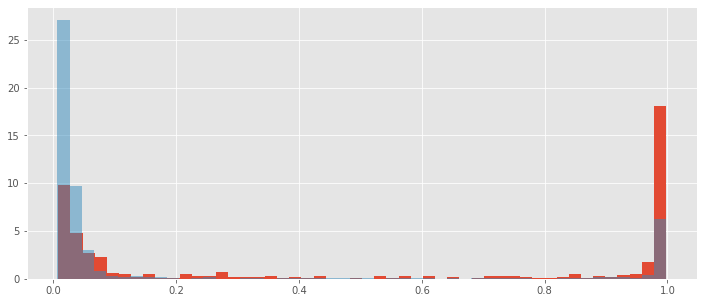

In [27]:
features = [
    'median_pred', 'std_pred', 'diff'
]

X_train = train_rows[features]
y_train = train_rows['swap_fake']
X_test = test_rows[features]
y_test = test_rows['swap_fake']

clf = LogisticRegression(random_state=42, multi_class='ovr').fit(X_train, y_train)
y_train_pred = clf.predict_proba(X_train)[:, 1]
y_test_pred = clf.predict_proba(X_test)[:, 1]
# print(y_pred)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.hist(y_test_pred, bins=50, density=True)
plt.hist(y_train_pred, bins=50, alpha=0.5, density=True)
print(max(y_train_pred), max(y_test_pred))

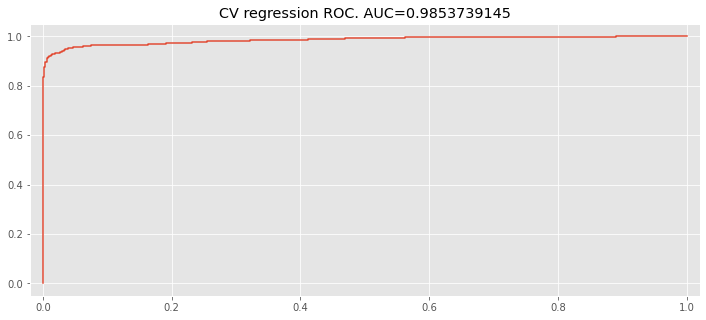

In [28]:
clip = -270
fpr, tpr, _ = sklearn.metrics.roc_curve(y_train, y_train_pred)
auc = sklearn.metrics.roc_auc_score(y_train, y_train_pred)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05])
plt.title("CV regression ROC. AUC="+str(round(auc, 10)))
plt.plot(fpr, tpr)

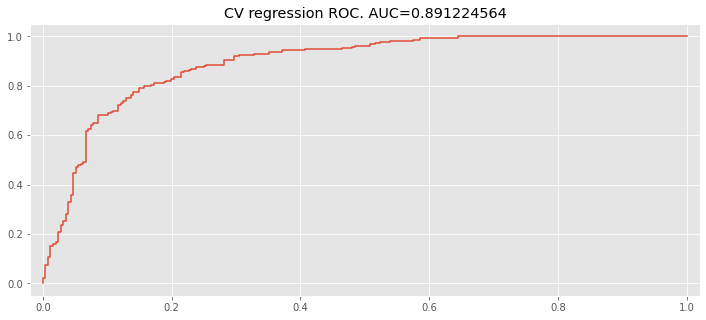

In [29]:
clip = -270
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_test_pred)
auc = sklearn.metrics.roc_auc_score(y_test, y_test_pred)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05])
plt.title("CV regression ROC. AUC="+str(round(auc, 10)))
plt.plot(fpr, tpr)

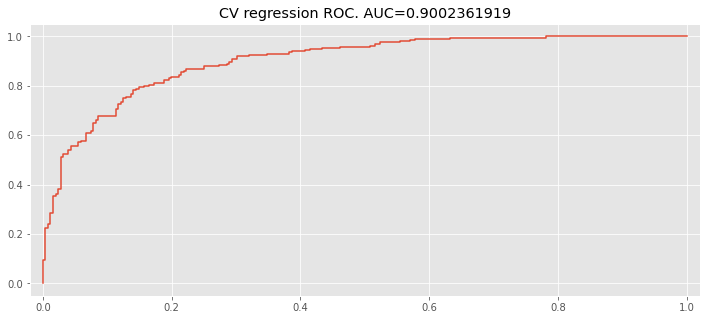

In [33]:
labels = test_rows['swap_fake']
preds = test_rows['median_pred']

fpr, tpr, _ = sklearn.metrics.roc_curve(labels, preds)
auc = sklearn.metrics.roc_auc_score(labels, preds)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05])
plt.title("CV regression ROC. AUC="+str(round(auc, 10)))
plt.plot(fpr, tpr)

,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
1055,55e4d92aa49c43b3.mp4,0,0.0,0.0,0,0,0.856923,0.938287,0.752128,0.986434,0.172703,0.999943,0.309458,0,-0.081364
1065,970a916177130046.mp4,0,0.0,0.0,0,0,0.701111,0.780506,0.547387,0.933626,0.264539,0.999793,0.022276,0,-0.079395
1206,04b84c827351f7dd.mp4,0,0.0,0.0,0,0,0.689772,0.776888,0.456310,0.954894,0.282769,0.999989,0.043215,0,-0.087117
1455,4aac2a4df11152b4.mp4,0,0.0,0.0,0,0,0.797870,0.896907,0.640834,0.986100,0.224978,1.000000,0.100134,0,-0.099037
1509,8f1f0b1b68f83018.mp4,0,0.0,0.0,0,0,0.831843,0.952599,0.746258,0.993548,0.243470,1.000000,0.045991,0,-0.120756
1668,581cd8ad78ed73eb.mp4,0,0.0,0.0,0,0,0.817316,0.909907,0.700986,0.991109,0.218111,0.999997,0.101594,0,-0.092591
1703,c2a975afb3342900.mp4,0,0.0,0.0,0,0,0.686387,0.769800,0.416673,0.978199,0.299881,0.999999,0.006179,0,-0.083413
1848,b06b726711834bf5.mp4,0,0.0,0.0,0,0,0.985719,0.999924,0.998382,0.999998,0.056533,1.000000,0.610096,0,-0.014205
1877,f2aafea8a142d65d.mp4,0,0.0,0.0,0,0,0.995420,0.999998,0.999896,1.000000,0.020700,1.000000,0.835380,0,-0.004579
1879,40cec6405e488058.mp4,0,0.0,0.0,0,0,0.693237,0.771805,0.491343,0.904413,0.258701,0.999999,0.073336,0,-0.078568


,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
717,664ffc49d4ed57c3.mp4,0,0.0,0.0,0,0,0.058188,0.028197,0.011493,0.070380,0.082728,0.454854,0.000207,0,0.029992
722,47b3da77499cbb41.mp4,0,0.0,0.0,0,0,0.102725,0.065377,0.036514,0.157707,0.094917,0.337187,0.004787,0,0.037348
741,c1b7b78abefc5f1b.mp4,0,0.0,0.0,0,0,0.129489,0.086708,0.046282,0.164927,0.162134,0.992174,0.007625,0,0.042781
749,3ab28b1865559901.mp4,0,0.0,0.0,0,0,0.116220,0.098149,0.059210,0.161678,0.076374,0.362004,0.016268,1,0.018071
751,e04b2802add08992.mp4,0,0.0,0.0,0,0,0.111988,0.103783,0.085480,0.132023,0.047053,0.270941,0.044305,0,0.008205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,55096740d4f7b805.mp4,1,0.0,0.0,1,0,0.997930,0.999991,0.999662,1.000000,0.006878,1.000000,0.950603,0,-0.002061
395,2671ac69a51a479d.mp4,1,0.0,0.0,1,0,0.999842,1.000000,0.999997,1.000000,0.000425,1.000000,0.998472,0,-0.000158
482,1d5466d6ce0ebf78.mp4,1,0.0,0.0,1,0,0.979889,0.999972,0.998997,1.000000,0.072428,1.000000,0.477631,0,-0.020083
223,dab618b437e283ef.mp4,1,0.0,0.0,1,0,0.992168,0.999995,0.999818,1.000000,0.042663,1.000000,0.653310,0,-0.007827


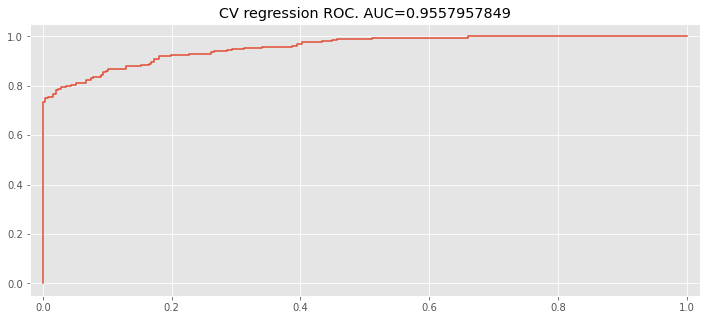

In [45]:
ideal_rows = test_rows.copy()
bad_cond = (
    (ideal_rows['swap_fake'] == 0) &
    (ideal_rows['median_pred'] > 0.7) 
)

bad_rows = ideal_rows[bad_cond]
display(bad_rows)
ideal_rows[bad_cond] = 0
ideal_rows['swap_fake'] = ideal_rows['swap_fake'].astype(int)
display(ideal_rows)

labels = ideal_rows['swap_fake']
preds = ideal_rows['median_pred']

fpr, tpr, _ = sklearn.metrics.roc_curve(labels, preds)
auc = sklearn.metrics.roc_auc_score(labels, preds)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05])
plt.title("CV regression ROC. AUC="+str(round(auc, 10)))
plt.plot(fpr, tpr)